MIT License

Copyright (c) 2019 Alexey Pechnikov, https://orcid.org/0000-0001-9626-8615 (ORCID)

See Linkedin articles

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import linregress

import matplotlib.pyplot as plt
%matplotlib inline

## Define functions

In [2]:
# band filter
def raster_filter_range(raster0, g1, g2):
    raster = raster0.copy()
    raster.values = raster.values.astype(np.float32)
    raster.values = gaussian_filter(raster.values,g1) - gaussian_filter(raster.values,g2)
    return raster

def spectrum(raster, gammas):
    rasters = []
    for g in gammas:
        print (g,". ", end = '')
        _raster = raster_filter_range(raster, g-.5, g+.5)
        rasters.append(_raster)
    return rasters

def correlogram(rasters1, rasters2, gammas):
    corrs = []
    for ridx in range(len(gammas)):
        print (ridx+1,". ", end = '')
        _raster2 = rasters2[ridx]
        for didx in range(len(gammas)):
            _raster1 = rasters1[didx]
            df = pd.DataFrame({'r1': _raster1.values.flatten(), 'r2': _raster2.values.flatten()})
            corr = round((df.corr()).iloc[0,1],2)
            corrs.append(corr)

    da_corr = xr.DataArray(np.array(corrs).reshape([len(gammas),len(gammas)]),
                          coords=[resolution*gammas,resolution*gammas],
                          dims=['r2','r1'])

    return da_corr

## Define parameters

In [3]:
# rasters below defined in projected coordinates system (EPSG:32645)
GEBCO="GEBCO_2019.subset.32645.2km.tif"
#GMRT="data.topo-mask.hires.32702.tif"
GRAVITY="grav_28.1.subset.32645.2km.tif"
#FREEAIR="WGM2012_Freeair.subset.32702.fixed.tif"

# define area
(minx, miny, maxx, maxy) = (-178267.33413097565, 2916881.3875568407, 618773.5038501866, 3378117.452931036)

# scale coefficient for rasters [km/pixel]
resolution = 2
# waveband in resolution units
GAMMA = 50
# waveband processing step
DGAMMA= 1

## Define discrete spectrum

In [4]:
gammas = np.arange(DGAMMA,GAMMA+DGAMMA/2,DGAMMA)

## Load rasters

### GEBCO_2019 topography

In [5]:
dem = xr.open_rasterio(GEBCO).rename({'x':'lon','y':'lat'})
dem.values[dem.values==dem.nodatavals[0]] = np.nan
del dem.attrs['units']
dem

<xarray.DataArray (band: 1, lat: 692, lon: 829)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * band     (band) int64 1
  * lat      (lat) float64 3.816e+06 3.814e+06 3.812e+06 ... 2.436e+06 2.434e+06
  * lon      (lon) float64 -6.395e+05 -6.375e+05 ... 1.014e+06 1.016e+06
Attributes:
    transform:   (2000.0, 0.0, -640501.4700283855, 0.0, -2000.0, 3817215.6180...
    crs:         +init=epsg:32645
    res:         (2000.0, 2000.0)
    is_tiled:    0
    nodatavals:  (9.969209968386869e+36,)
    scales:      (1.0,)
    offsets:     (0.0,)

### Sandwell and Smith Gravity Anomaly

In [6]:
grv = xr.open_rasterio(GRAVITY).rename({'x':'lon','y':'lat'})
grv

<xarray.DataArray (band: 1, lat: 692, lon: 828)>
[572976 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * lat      (lat) float64 3.816e+06 3.814e+06 3.812e+06 ... 2.436e+06 2.434e+06
  * lon      (lon) float64 -6.395e+05 -6.375e+05 ... 1.012e+06 1.014e+06
Attributes:
    transform:   (2000.0, 0.0, -640501.4700283855, 0.0, -2000.0, 3817215.6180...
    crs:         +init=epsg:32645
    res:         (2000.0, 2000.0)
    is_tiled:    0
    nodatavals:  (nan,)
    scales:      (1.0,)
    offsets:     (0.0,)

## Crop area

In [7]:
dem = dem.sel(lat=slice(maxy,miny),lon=slice(minx,maxx))
grv = grv.sel(lat=slice(maxy,miny),lon=slice(minx,maxx))

maxx-minx, maxy-miny

(797040.8379811622, 461236.0653741951)

## Plot datasets

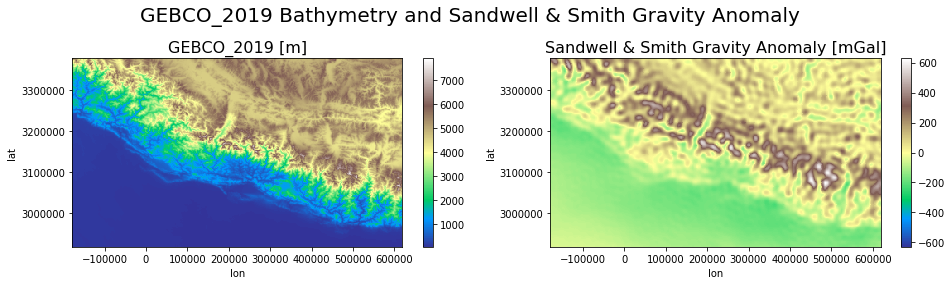

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4))

dem.plot(ax=ax1, cmap='terrain')
ax1.set_title('GEBCO_2019 [m]',fontsize=16)

grv.plot(ax=ax2, cmap='terrain')
ax2.set_title('Sandwell & Smith Gravity Anomaly [mGal]',fontsize=16)

fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.suptitle('GEBCO_2019 Bathymetry and Sandwell & Smith Gravity Anomaly',fontsize=20)
plt.savefig('GEBCO_2019 and Sandwell and Smith Gravity Anomaly.jpg', dpi=150)
plt.show()


## Spectrums calculation

In [9]:
dems = spectrum(dem, gammas)
grvs = spectrum(grv, gammas)

1.0 . 2.0 . 3.0 . 4.0 . 5.0 . 6.0 . 7.0 . 8.0 . 9.0 . 10.0 . 11.0 . 12.0 . 13.0 . 14.0 . 15.0 . 16.0 . 17.0 . 18.0 . 19.0 . 20.0 . 21.0 . 22.0 . 23.0 . 24.0 . 25.0 . 26.0 . 27.0 . 28.0 . 29.0 . 30.0 . 31.0 . 32.0 . 33.0 . 34.0 . 35.0 . 36.0 . 37.0 . 38.0 . 39.0 . 40.0 . 41.0 . 42.0 . 43.0 . 44.0 . 45.0 . 46.0 . 47.0 . 48.0 . 49.0 . 50.0 . 1.0 . 2.0 . 3.0 . 4.0 . 5.0 . 6.0 . 7.0 . 8.0 . 9.0 . 10.0 . 11.0 . 12.0 . 13.0 . 14.0 . 15.0 . 16.0 . 17.0 . 18.0 . 19.0 . 20.0 . 21.0 . 22.0 . 23.0 . 24.0 . 25.0 . 26.0 . 27.0 . 28.0 . 29.0 . 30.0 . 31.0 . 32.0 . 33.0 . 34.0 . 35.0 . 36.0 . 37.0 . 38.0 . 39.0 . 40.0 . 41.0 . 42.0 . 43.0 . 44.0 . 45.0 . 46.0 . 47.0 . 48.0 . 49.0 . 50.0 . 

## Correlogram calculation

In [10]:
da_grv_corr = correlogram(dems, grvs, gammas)

1 . 2 . 3 . 4 . 5 . 6 . 7 . 8 . 9 . 10 . 11 . 12 . 13 . 14 . 15 . 16 . 17 . 18 . 19 . 20 . 21 . 22 . 23 . 24 . 25 . 26 . 27 . 28 . 29 . 30 . 31 . 32 . 33 . 34 . 35 . 36 . 37 . 38 . 39 . 40 . 41 . 42 . 43 . 44 . 45 . 46 . 47 . 48 . 49 . 50 . 

In [11]:
float(da_grv_corr.min()),float(da_grv_corr.max())

(0.01, 0.94)

## Plot correlogram

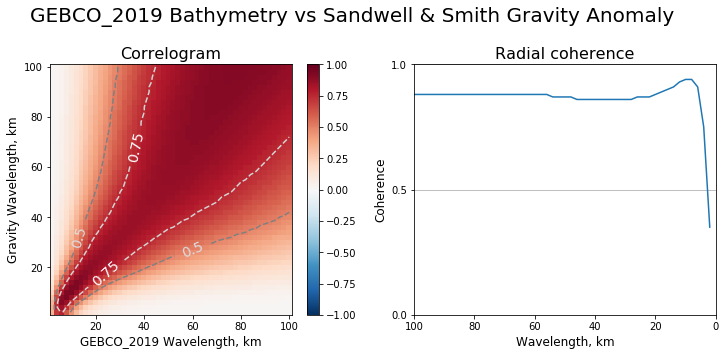

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10.5,5))

da_grv_corr.plot(cmap='RdBu_r',ax=ax1, vmin=-1,vmax=1)
contours = da_grv_corr.plot.contour(levels=[.5,.75],colors=['gray','lightgray'],linestyles='--',ax=ax1)
ax1.clabel(contours, contours.levels, inline=True, fmt='%r', colors=['gainsboro','white'], fontsize=14)
ax1.set_xlabel('GEBCO_2019 Wavelength, km',fontsize=12)
ax1.set_ylabel('Gravity Wavelength, km',fontsize=12)
ax1.set_title('Correlogram',fontsize=16)

ax2.plot(resolution*gammas, [float(da_grv_corr[g,g]) for g in range(len(gammas))])
ax2.set_xlabel('Wavelength, km',fontsize=12)
ax2.set_ylabel('Coherence',fontsize=12)
ax2.set_yticks([0,0.5,1])
ax2.yaxis.grid(True)
ax2.set_xlim([resolution*GAMMA,0])
ax2.set_title('Radial coherence',fontsize=16)

plt.suptitle('GEBCO_2019 Bathymetry vs Sandwell & Smith Gravity Anomaly',fontsize=20)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.savefig('GEBCO_2019 vs Sandwell and Smith Gravity Anomaly.jpg', dpi=150)
plt.show()

## Fractal Dimension Index calculation

In [13]:
dem_stds = [_.std() for _ in dems]
grv_stds = [_.std() for _ in grvs]

In [14]:
slope = np.diff(np.log10(dem_stds))/np.diff(np.log10(resolution*gammas))
dem_fractality = (3 - (slope/2))

slope = np.diff(np.log10(grv_stds))/np.diff(np.log10(resolution*gammas))
grv_fractality = (3 - (slope/2))

In [15]:
# define real depth
depths = 0.707*resolution*(gammas[1:] - DGAMMA/2)
depths_surface = -float(dem.mean())/1000+depths

## Density Model by Fractal Dimension Index

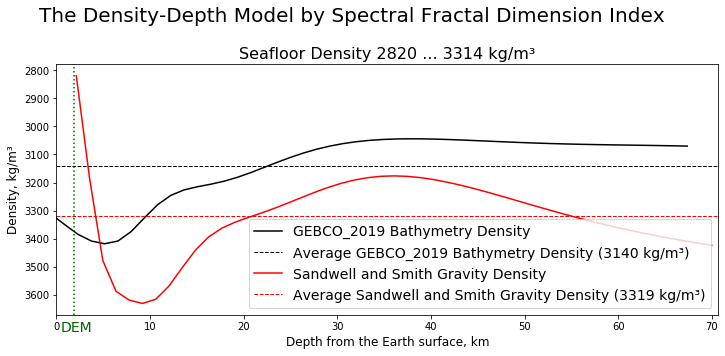

In [16]:
fig, ax = plt.subplots(1,1,figsize=(10.5,5))

ax.plot(depths_surface, 1000*dem_fractality, c='black', label='GEBCO_2019 Bathymetry Density')
ax.axhline(y=1000*dem_fractality.mean(), xmin=0, xmax=1, color = 'black', ls='--', lw=1,
           label='Average GEBCO_2019 Bathymetry Density (%d kg/m³)' % int(np.round(1000*dem_fractality.mean())))

ax.plot(depths, 1000*grv_fractality, c='red',label='Sandwell and Smith Gravity Density')
ax.axhline(y=1000*grv_fractality.mean(), xmin=0, xmax=1, color = 'red', ls='--', lw=1,
           label='Average Sandwell and Smith Gravity Density (%d kg/m³)' % int(np.round(1000*grv_fractality.mean())))

ax.set_xlim([0,0.707*resolution*GAMMA])

ax.legend(loc='lower right', fontsize=14)
ax.set_xlabel('Depth from the Earth surface, km',fontsize=12)
ax.set_ylabel('Density, kg/m³',fontsize=12)
ax.invert_yaxis()
#ax.grid()

ax.axvline(x=.707*dem.mean()/1000, ymin=0, ymax=1, color = 'darkgreen', ls='dotted')
ax.text(.4, 3730, "DEM", color="darkgreen", fontsize=14)

plt.suptitle('The Density-Depth Model by Spectral Fractal Dimension Index',fontsize=20)
plt.title('Seafloor Density %d ... %d kg/m³' % 
              (int(np.round(1000*grv_fractality[0])),int(np.round(1000*dem_fractality[0]))),fontsize=16)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.savefig('Density Model by Fractal Dimension Index.jpg', dpi=150)
plt.show()